<h1>Automated correction factors calculation from smFRET data</h1>

This notebook contains scripts to automatically calculate the correction factors for TIRF-based smFRET data and apply those corrections to the dataset

In [1]:
#Import necessary packages
import xarray as xr             #For data retreival and processing
import matplotlib.pyplot as plt #For plotting
import numpy as np              #For processing arrays
import glob, os                 #For folder search
import matplotlib
# %matplotlib inline
from scipy.optimize import curve_fit


In [2]:
def total_mean_int(root_path, frames=[0,13]):
    # root_path = r'E:\Data\02 FRETFluc\20230217_138p_7N_3N_R1P_Cy3_Fluo\ch_138p_R1P_Cy3_500ms'
    nc_list = glob.glob(root_path )
    fr1,fr2 = frames    #Number of frames to extract
    ds = []             #Array to store individual .nc datasets (necessary??)
    donor_intensity = []    #Array to store donor intensities from datasets
    acceptor_intensity = [] #Array to store acceptor intensities from datasets
    #acceptor_excitation = []    #Array to store acceptor intensities (from acceptor excitation) from datasets (not used currently)

    #Loop through all .nc files and extract donor and acceptor intensities
    for fname in nc_list:
        nc_fname = os.path.join(root_path, fname)
        # nc_fname = os.path.join(root_path, f'*.nc')
        print(nc_fname)
        tmp_ds = xr.load_dataset(nc_fname, engine='h5netcdf')
        ds.append(tmp_ds)
        donor_intensity.append(tmp_ds.intensity[:,0].isel(frame=slice(fr1,fr2)).mean("frame"))
        acceptor_intensity.append(tmp_ds.intensity[:,1].isel(frame=slice(fr1,fr2)).mean("frame"))
        # acceptor_excitation.append(tmp_ds.intensity[:,1,1::2].isel(frame=slice(fr1,fr2)).mean("frame"))

    d_int = []
    a_int = []
    # a_exc = []
    #Rewrite this part using numpy's function -- flattening the array
    for i in range(len(donor_intensity)):
        d_int = np.concatenate((donor_intensity[i],d_int))
        a_int = np.concatenate((acceptor_intensity[i],a_int))
        # a_exc = np.concatenate((acceptor_excitation[i],a_exc))
    return d_int, a_int

N:\tnw\BN\Shared\Archana_N\Microscopy TIR-S\20230511 ssRNA Trial 2\Casimer project data set\ch001_fov000.nc
N:\tnw\BN\Shared\Archana_N\Microscopy TIR-S\20230511 ssRNA Trial 2\Casimer project data set\ch001_fov001.nc
N:\tnw\BN\Shared\Archana_N\Microscopy TIR-S\20230511 ssRNA Trial 2\Casimer project data set\ch001_fov002.nc
N:\tnw\BN\Shared\Archana_N\Microscopy TIR-S\20230511 ssRNA Trial 2\Casimer project data set\ch001_fov003.nc
N:\tnw\BN\Shared\Archana_N\Microscopy TIR-S\20230511 ssRNA Trial 2\Casimer project data set\ch001_fov004.nc
N:\tnw\BN\Shared\Archana_N\Microscopy TIR-S\20230511 ssRNA Trial 2\Casimer project data set\ch001_fov005.nc
N:\tnw\BN\Shared\Archana_N\Microscopy TIR-S\20230511 ssRNA Trial 2\Casimer project data set\ch001_fov006.nc
N:\tnw\BN\Shared\Archana_N\Microscopy TIR-S\20230511 ssRNA Trial 2\Casimer project data set\ch001_fov007.nc
N:\tnw\BN\Shared\Archana_N\Microscopy TIR-S\20230511 ssRNA Trial 2\Casimer project data set\ch001_fov008.nc


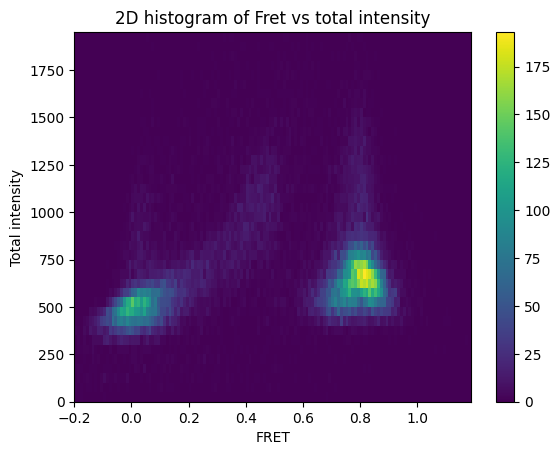

In [3]:

#Import folder with .nc files (excluding background correction files)
donor_int, acceptor_int = total_mean_int(r'N:\tnw\BN\Shared\Archana_N\Microscopy TIR-S\20230511 ssRNA Trial 2\Casimer project data set\*nc')

#Bins for intensity and FRET efficiency
bins_i = np.arange(0, 2000, 50)     #For TIR-S, 0-2000 is reasonable -- change it for other microscopes
bins_f = np.arange(-0.2,1.2,0.01)   #FRET efficiency spanning 0 to 1, but padded by 0.2 on either end

#Calculate total intensity and FRET efficiency for the dataset
total_intensity = donor_int + acceptor_int
fret = acceptor_int / (total_intensity)

#Plot 2D-histogram of Total Intensity v/s FRET Efficiency
plt.hist2d(fret, total_intensity, bins=[bins_f,bins_i])
plt.title('2D histogram of Fret vs total intensity')
plt.xlabel('FRET')
plt.ylabel('Total intensity')
plt.colorbar()
plt.show()

C:\Users\archanasivaram\AppData\Roaming\Python\Python39\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


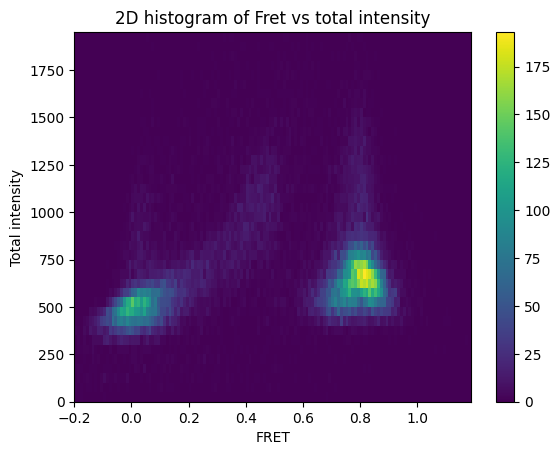

In [4]:
# Define the 2D Gaussian function to fit
def gaussian2D(xy, amplitude, xo, yo, sigma_x, sigma_y):
    x, y = xy
    xo = float(xo)
    yo = float(yo)
    a = 1 / (2 * sigma_x**2)
    b = 1 / (2 * sigma_y**2)
    g = amplitude * np.exp(-((a * (x - xo)**2) + (b * (y - yo)**2)))
    return g.ravel()

# Plot 2D-histogram of Total Intensity v/s FRET Efficiency
plt.hist2d(fret, total_intensity, bins=[bins_f, bins_i])
plt.title('2D histogram of Fret vs total intensity')
plt.xlabel('FRET')
plt.ylabel('Total intensity')
plt.colorbar()


# Fit a 2D Gaussian to the histogram
hist, x_edges, y_edges = np.histogram2d(fret, total_intensity, bins=[bins_f, bins_i])
x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2
X, Y = np.meshgrid(x_centers, y_centers)
xy = np.vstack((X.ravel(), Y.ravel()))

# Initial parameters
initial_guess = [np.max(hist), np.mean(fret), np.mean(total_intensity), 0.1, 0.1]

# Fit the Gaussian function to the histogram using curve_fit
popt, pcov = curve_fit(gaussian2D, xy, hist.ravel(), p0=initial_guess)

# Extract the mean1 and mean2 values from the fitted parameters
mean1 = popt[1]
mean2 = popt[2]
plt.show()


In [5]:
#Define Ierror

Ierror = math.sqrt((mean2-mean1)^2)

for Gamma in np.arange(1,2.5,0.01)
    print("Current Gamma iteration: ", Gamma)
    
    d_intCorrected = donor_int*Gamma 
    total_intensityC = d_intCorrected + acceptor_int
    fretC = acceptor_int / (total_intensityC)
    
    # plot 2D gaussian 
    #plt.hist2d(fretC, total_intensityC, bins=[bins_f, bins_i])
    #plt.title('2D histogram of Fret vs total intensity Corrected')
    #plt.xlabel('FRET')
    #plt.ylabel('Total intensity')
    
    #Calculate mean 
    hist, x_edges, y_edges = np.histogram2d(fret, total_intensity, bins=[bins_f, bins_i])
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
    X, Y = np.meshgrid(x_centers, y_centers)
    xy = np.vstack((X.ravel(), Y.ravel()))

    # Gaussian parameters
    initial_guess = [np.max(hist), np.mean(fret), np.mean(total_intensity), 0.1, 0.1]

    # Fit the Gaussian function to the histogram using curve_fit
    popt, pcov = curve_fit(gaussian2D, xy, hist.ravel(), p0=initial_guess)

    # Extract the mean1 and mean2 values from the fitted parameters
    meanC1 = popt[1]
    meanC2 = popt[2]
    
    IerrorC = math.sqrt((meanC2-meanC1)^2)
     
    if IerrorC < Ierror:
       continue;
    else: 
       break;
        
plt.plot (fretC, IerrorC,0)

print("Gamma : ", Gamma)
print("Ierror : ", Ierror)
print("IerrorC : ", IerrorC)
print("Mean C1 : ", meanC1)
print("Mean C2 : ", meanC2)
    

SyntaxError: invalid syntax (1160703600.py, line 5)